In [1]:
import rospy
import time
import numpy as np
from nav_msgs.msg import OccupancyGrid
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from scipy.ndimage.morphology import distance_transform_edt as bwdist
from PIL import Image

In [2]:
im = Image.open("/home/scifiswapnil/Desktop/robotics_project_001/src/hector_formation/map/map_ mod.pgm")

In [3]:
a = np.asarray(im)

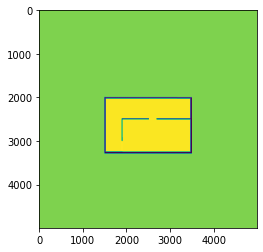

In [4]:
plt.imshow(a)
# a

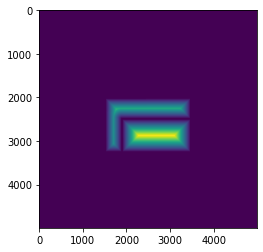

In [74]:
d = bwdist(a==253)
plt.imshow(d)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
odata = None
def callback(data):
    global odata
    odata = data
    rospy.loginfo(rospy.get_caller_id() + "I heard %s")

In [ ]:
rospy.init_node('listener', anonymous=True)
rospy.Subscriber("/map", OccupancyGrid, callback)
time.sleep(2)
# rospy.spin()

In [10]:
import cv2  

In [ ]:
type(odata)

In [ ]:
def occupancygrid_to_numpy(msg):
    data = np.asarray(msg.data, dtype=np.uint8).reshape(msg.info.height, msg.info.width)
    return np.array(data)

In [ ]:
a = occupancygrid_to_numpy(odata)

In [ ]:
def numpy_to_occupancy_grid(arr, info=None):
    if not len(arr.shape) == 2:
        raise TypeError('Array must be 2D')
    if not arr.dtype == np.int8:
        raise TypeError('Array must be of int8s')
    grid = OccupancyGrid()
    if isinstance(arr, np.ma.MaskedArray):
    # We assume that the masked value are already -1, for speed
        arr = arr.data
        grid.data = arr.ravel()
        grid.info = info or MapMetaData()
        grid.info.height = arr.shape[0]
        grid.info.width = arr.shape[1]
    return grid

In [11]:
aa = cv2.resize(a, (600,600))
cv2.imshow("Simple_black", aa)
cv2.waitKey(0)
cv2.destroyAllWindows()

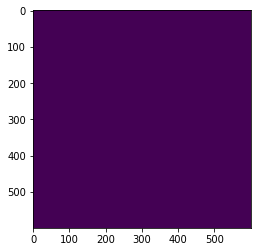

In [71]:
d = bwdist(aa==543)
plt.imshow(d)

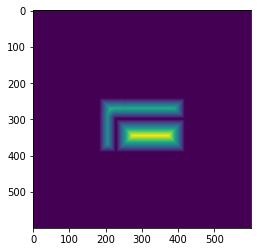

In [50]:
plt.imshow((d/100.)+1)

In [66]:
def combined_potential(obstacles_grid, goal, influence_radius=.02, attractive_coef=1./2000, repulsive_coef=900, nrows=600, ncols=600):
    """ Repulsive potential """
    d = bwdist(obstacles_grid==253)
    d2 = (d/100)  # Rescale and transform distances
    d0 = influence_radius + 1
    nu = repulsive_coef
    repulsive = nu*((1/d2 - 1/d0)**2)
    repulsive [d2 > d0] = 0
    """ Attractive potential """
    [x, y] = np.meshgrid(np.arange(ncols), np.arange(nrows))
    xi = attractive_coef
    attractive = xi * ( (x - goal[0])**2 + (y - goal[1])**2 )
    """ Combine terms """
    total = attractive + repulsive
    return total, attractive, repulsive

In [54]:
def gradient_planner (f, start, goal, max_its):
    # GradientBasedPlanner : This function plans a path through a 2D
    # environment from a start to a destination based on the gradient of the
    # function f which is passed in as a 2D array. The two arguments
    # start_coords and end_coords denote the coordinates of the start and end
    # positions respectively in the array while max_its indicates an upper
    # bound on the number of iterations that the system can use before giving
    # up.
    # The output, route, is an array with 2 columns and n rows where the rows
    # correspond to the coordinates of the robot as it moves along the route.
    # The first column corresponds to the x coordinate and the second to the y coordinate

    [gy, gx] = np.gradient(-f);
    start_coords = start; end_coords = goal
    route = np.array( [np.array(start_coords)] )
    for i in range(max_its):
        current_point = route[-1,:];
        # print(sum( abs(current_point-end_coords) ))
        if sum( abs(current_point-end_coords) ) < 5.0:
            # print('Reached the goal !');
            break
        ix = int( current_point[1] )
        iy = int( current_point[0] )
        vx = gx[ix, iy]
        vy = gy[ix, iy]
        dt = 1 / np.linalg.norm([vx, vy]);
        next_point = current_point + dt*np.array( [vx, vy] );
        route = np.vstack( [route, next_point] );
#     route = grid2meters(route)
    
    return route

<ipython-input-66-b9fdc587586d>:7: RuntimeWarning: divide by zero encountered in true_divide
  repulsive = nu*((1/d2 - 1/d0)**2)


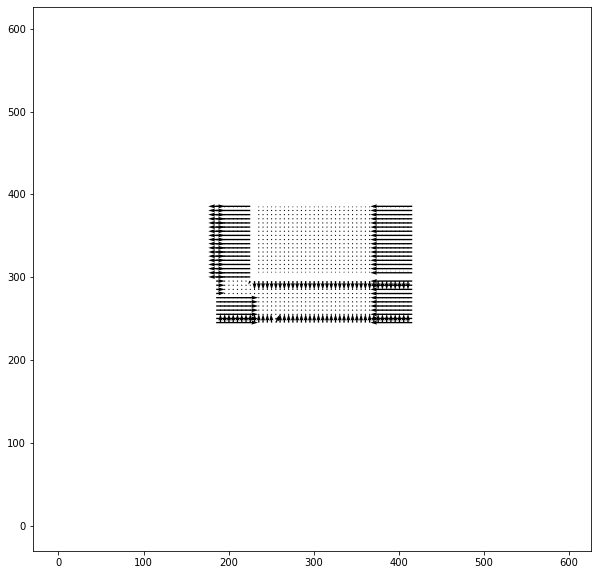

In [67]:
b,c,d = combined_potential(aa,(300,300))
plt.figure(figsize=(10,10))

# # Combined potential
# f = combined_potential(obstacles_grid, xy_goal)
# # Plan route
# route = gradient_planner(b, (300,550), (300,300), 700)
draw_gradient(b)
# plt.plot(route[:,0], route[:,1], linewidth=5)
# plt.plot(xy_start[0],xy_start[1],'bo',color='red', markersize=10, label='start')
# plt.plot(xy_goal[0], xy_goal[1],'bo',color='green', markersize=10, label='goal')
# plt.legend()

In [62]:
def draw_gradient(f, nrows=600, ncols=600):
    skip = 5
    [x_m, y_m] = np.meshgrid(np.linspace(0, 600, ncols), np.linspace(0, 600, nrows))
    [gy, gx] = np.gradient(-f);
    Q = plt.quiver(x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip])